In [1]:
from __future__ import absolute_import

In [2]:
from __future__ import division
from __future__ import print_function


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
tf.logging.set_verbosity(tf.logging.INFO)

In [4]:
np.random.seed(1)

In [5]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/datas

y = 0


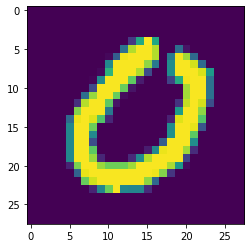

In [6]:
train_data.shape
index = 7
plt.imshow(train_data[index].reshape(28, 28))
print ("y = " + str(np.squeeze(train_labels[index])))

In [7]:
print ("number of training examples = " + str(train_data.shape[0]))
print ("number of evaluation examples = " + str(eval_data.shape[0]))
print ("X_train shape: " + str(train_data.shape))
print ("Y_train shape: " + str(train_labels.shape))
print ("X_test shape: " + str(eval_data.shape))
print ("Y_test shape: " + str(eval_labels.shape))

number of training examples = 55000
number of evaluation examples = 10000
X_train shape: (55000, 784)
Y_train shape: (55000,)
X_test shape: (10000, 784)
Y_test shape: (10000,)


In [8]:
def cnn_model_fn(features, labels, mode):
    # Input Layer
    input_height, input_width = 28, 28
    input_channels = 1
    input_layer = tf.reshape(features["x"], [-1, input_height, input_width, input_channels])

    # Convolutional Layer #1 and Pooling Layer #1
    conv1_1 = tf.layers.conv2d(inputs=input_layer, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv1_2 = tf.layers.conv2d(inputs=conv1_1, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1_2, pool_size=[2, 2], strides=2, padding="same")
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2_1 = tf.layers.conv2d(inputs=pool1, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv2_2 = tf.layers.conv2d(inputs=conv2_1, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2_2, pool_size=[2, 2], strides=2, padding="same")

    # Convolutional Layer #3 and Pooling Layer #3
    conv3_1 = tf.layers.conv2d(inputs=pool2, filters=256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv3_2 = tf.layers.conv2d(inputs=conv3_1, filters=256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3_2, pool_size=[2, 2], strides=2, padding="same")

    # Convolutional Layer #4 and Pooling Layer #4
    conv4_1 = tf.layers.conv2d(inputs=pool3, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv4_2 = tf.layers.conv2d(inputs=conv4_1, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool4 = tf.layers.max_pooling2d(inputs=conv4_2, pool_size=[2, 2], strides=2, padding="same")

    # Convolutional Layer #5 and Pooling Layer #5
    conv5_1 = tf.layers.conv2d(inputs=pool4, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv5_2 = tf.layers.conv2d(inputs=conv5_1, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool5 = tf.layers.max_pooling2d(inputs=conv5_2, pool_size=[2, 2], strides=2, padding="same")

    # FC Layers
    pool5_flat = tf.contrib.layers.flatten(pool5)
    FC1 = tf.layers.dense(inputs=pool5_flat, units=4096, activation=tf.nn.relu)
    FC2 = tf.layers.dense(inputs=FC1, units=4096, activation=tf.nn.relu)
    FC3 = tf.layers.dense(inputs=FC2, units=1000, activation=tf.nn.relu)

    
    dropout = tf.layers.dropout(inputs=FC3, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Logits Layer or the output layer. return the raw values for our predictions.
    # Like FC layer, logits layer is another dense layer. 
    # apply the softmax
    logits = tf.layers.dense(inputs=dropout, units=10)
    
   
    predictions = {
       
        "classes": tf.argmax(input=logits, axis=1),
        
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

   
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels,
                                        predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode,
                                      loss=loss,
                                      eval_metric_ops=eval_metric_ops)


In [ ]:
mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)

train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": train_data},
                                                    y=train_labels,
                                                    batch_size=200,
                                                    num_epochs=1,
                                                    shuffle=False)
mnist_classifier.train(input_fn=train_input_fn,
                       steps=None,
                       hooks=None)


eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": eval_data},
                                                   y=eval_labels,
                                                   num_epochs=1,
                                                   shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)